In [ ]:
pip install tensorflow
pip install requests
pip install pandas
pip install matplotlib
pip install torch
pip install plotly

In [ ]:
pip install torch

In [3]:
def merge_json_objects(obj1, obj2):
    merged_data = {}

    #add ojb1 into holding dict. if key is found in both, merge them then add
    for key, value in obj1.items():
        if key in obj2:
            merged_data[key] = value+obj2[key]
        else:
            merged_data[key] = value

    #add obj2 into holding dict only if key not in obj1
    for key, value in obj2.items():
        if key not in merged_data:
            merged_data[key] = value
            
    return merged_data

In [4]:
def get_stock_data(url, next_page_token=None):
    # Make a request to the stock price endpoint
    apiKey = 'PKVVMO4VIR8019Z87DV6'
    apiSecret = 'XlEHA9LpAe3lCmbASJY1Ffze3aRhmCdkhvM1SBnf'
    headers = {
        "accept": "application/json",
        "APCA-API-KEY-ID": apiKey,
        "APCA-API-SECRET-KEY": apiSecret
    }
    response = requests.get(url+next_page_token, headers=headers)
    
    # Check if the response is successful
    if response.status_code == 200:
        # Parse the JSON response
        json_data = response.json()
        bars = json_data['bars']
        # Extract stock data from the current page
        current_page_data = {key: bars[key] for key in bars.keys()}
        # Check if there is a next page
        next_page_token = json_data.get('next_page_token')
        if next_page_token is not None:
            # Recursively fetch and merge the next page data
            next_page_data = get_stock_data(url, '&page_token='+next_page_token)
            current_page_data = merge_json_objects(current_page_data, next_page_data)

        return current_page_data

    else:
        # Handle the case where the API request was not successful
        print(f"Error: {response.status_code}")
        return None


In [5]:
import pandas as pd
import requests
from datetime import datetime
import numpy as np

#gets stock data and cleans it
def stock_data(symbols, pathParam, queryParams):
    #base url to build off of
    base_url = "https://data.alpaca.markets/v2/stocks/"

    #add specific api path
    base_url += pathParam

    #add stock symbols to url
    base_url += 'symbols='
    for symbol in symbols:
        base_url += symbol + "%2C";
        base_url[:-3]

    #add params to urls
    for key, value in queryParams.items():
        base_url += "&";
        base_url += key;
        base_url += "=";
        base_url += value;

    #get merged price data
    results = get_stock_data(base_url, '')

    #create list of symbols. FIXME: this could probably use the symbols param. dont know which is faster
    symbols = list(results.keys())
    #create empty dict to hold each symbols data
    tables = {}
    for symbol in symbols:
        #get specific symbol's data
        data = results[symbol]
        
        # Convert timestamp strings to datetime objects
        for point in data:
            #FIXME: make sure every endpoint includes 't' measure
            point["t"] = datetime.strptime(point["t"], "%Y-%m-%dT%H:%M:%SZ")
        
        # Create a Pandas DataFrame
        df = pd.DataFrame(data)
            
            
        # FIXME: This is not needed in prod. Wasted computation. Not agnostic
        df.rename(columns={'c': 'close', 'h':'high', 'l':'low', 'n':'trade_count', 'o':'open', 't':'timestamp', 'v':'bar_volume', 'vw':'price_volume_weighted'}, inplace=True)
    
        # add df to dictionary of dfs
        tables[symbol] = df

    return tables


In [6]:
def create_MACD(data, config):
    shortPeriod = config['shortPeriod']
    longPeriod = config['longPeriod']
    signalPeriod = config['signalPeriod']

    #Calculate short and long ewma used to calculate the final macd
    macdShort=pd.Series(data['price_volume_weighted'].ewm(span=shortPeriod, min_periods=1, adjust=False).mean())
    macdLong=pd.Series(data['price_volume_weighted'].ewm(span=longPeriod, min_periods=1, adjust=False).mean())
    macd = pd.Series(macdShort - macdLong, name='value')
    signal = pd.Series(macd.ewm(span=signalPeriod, min_periods=1, adjust=False).mean())
    crossover = macd-signal
    indicator = pd.concat([data, crossover], axis=1)
    return indicator
    

def create_RSI(data, config):
    period = config['period']
    price_change=pd.Series(data['price_volume_weighted'].diff())

    # Calculate the average gain and average loss over a x-day period
    gain=pd.Series(price_change.apply(lambda x: x if x > 0 else 0))
    loss=pd.Series(price_change.apply(lambda x: abs(x) if x < 0 else 0))
    avg_gain=pd.Series(gain.rolling(window=period, min_periods=1).mean())
    avg_loss=pd.Series(loss.rolling(window=period, min_periods=1).mean())

    # avg_gain=pd.Series(gain.ewm(span=period, min_periods=1, adjust=False).mean())
    # avg_loss=pd.Series(loss.ewm(span=period, min_periods=1, adjust=False).mean())
        
    # Calculate the relative strength (RS)
    rs = avg_gain / avg_loss

    # Calculate the RSI
    rsi = pd.Series(100 - (100 / (1 + rs)), name='value')
    indicator = pd.concat([data, rsi], axis=1)
    return indicator
    
    
def create_SMA(data, config):
    period = config['period']

    #Calculate simple moving avg
    ma=pd.Series(data['price_volume_weighted'].rolling(window=period).mean(), name='value')
    indicator=pd.concat([data, ma], axis=1)
    return indicator
    

def create_PriceDelta(data, config):
    period = config['period']

    #Calculate simple price change from previous
    delta=pd.Series(data['price_volume_weighted'] - data['price_volume_weighted'].shift(period), name='value')
    indicator=pd.concat([data, delta], axis=1)
    return indicator


def create_PriceDeltaPercent(data, config):
    period = config['period']
    point = config['point']

    #Calculate simple price change from previous (percent)
    delta=pd.Series(abs(data['price_volume_weighted']-data['price_volume_weighted'].shift(period)))
    final = pd.Series((delta/data['price_volume_weighted'].shift(period))*100, name='value') if point == 'initial' else pd.Series((delta/data['price_volume_weighted'])*100, name='value')
    indicator=pd.concat([data, final], axis=1)
    return indicator

def create_EWMA(data, config):
    period = config['period']

    #Calculate ewma
    ewma = pd.Series(data['price_volume_weighted'].ewm(span=period, min_periods=1).mean(), name='value')
    indicator=pd.concat([data, ewma], axis=1)
    return indicator

#map indicator names to their build functions
indicator_functions = {
    'MACD': create_MACD,
    'RSI': create_RSI,
    'SMA': create_SMA,
    'PriceDelta': create_PriceDelta,
    'PriceDeltaPercent': create_PriceDeltaPercent,
    'EWMA': create_EWMA
}

In [7]:
def create_indicators(stocks, indicator_config):
    indicators_master = {}

    #for each symbol calculate all the indicators given in the config param
    for symbol, data in stocks.items():
        symbol_indicators = {}
        for indicator_name, config in indicator_config.items():
            
            # Use the indicator_functions dictionary to get the appropriate function
            indicator_function = indicator_functions.get(indicator_name)
            if indicator_function:
                
                # Call the selected function with the corresponding configuration
                indicator_value = indicator_function(data, config)
                symbol_indicators[indicator_name] = indicator_value
            else:
                print(f"Warning: Unknown indicator '{indicator}'. Skipping.")
        indicators_master[symbol] = symbol_indicators
    return indicators_master

In [8]:
def create_signals(stocks, signal_memory, cutin, cutoff):
    signals_final = {}

    #Create the signals for each symbol
    for symbol, bars in stocks.items():

        #flip list for easier ewma calculation for future prices, with higher weight for more recent prices
        flipped = bars['price_volume_weighted'][::-1]
        flipped_ewma = flipped.ewm(span=signal_memory, min_periods=0, adjust=False).mean()

        #flip list back
        ewma = flipped_ewma[::-1]

        #signal is simply the change from now to ewma of future x prices
        future_change = ewma - bars['price_volume_weighted']
        signal = pd.Series(future_change/bars['price_volume_weighted'], name = 'value')
        full_df = pd.concat([bars[['timestamp']], signal], axis=1)
        signals_final[symbol] = full_df.iloc[cutin:-cutoff].reset_index(drop=True)
    return signals_final

In [9]:
def min_max_scaling(data):
    
    # simple min max scaling to normalize indicators
    min_val = np.min(data['value'])
    max_val = np.max(data['value'])
    scaled_data = (data['value'] - min_val) / (max_val - min_val)
    scaled=pd.concat([data['timestamp'], scaled_data], axis=1)
    return scaled

In [10]:
# Clean and format data
def create_features(indicators, cutin, cutoff):
    features = {}
    features_scaled={}
    outputs = {}

    #normalize every indicator for each symbol (feature=indicator)
    for symbol, indicator_dict in indicators.items():
        feature = {}
        feature_scaled = {}
        output = []
        for indicator_name, indicator_value in indicator_dict.items():
            feature[indicator_name] = indicator_value[['value', 'timestamp']].iloc[cutin:-cutoff].reset_index(drop=True)
            feature_scaled[indicator_name] = min_max_scaling(feature[indicator_name])
        features[symbol]=feature
        features_scaled[symbol]=feature_scaled
    return features, features_scaled

In [11]:
#main flow
def main(symbols, queryParams, pathParam, indicator_config, signal_memory):

    #define values for trimming features. needed because some features are caclulated from periods
    #Ex: moving avg 50 pts needs 50 data points (if not using today) to calculate 51st value, so first 50 values are NaN
    #FIXME: this should be automatic
    cutin = 51
    cutoff = 1

    #get stock data for given symbols
    stock_bars = stock_data(symbols, pathParam, queryParams)

    #calculate indicators from stock data
    indicators = create_indicators(stock_bars, indicator_config)

    #create features from indicators (clean and normalize)
    features, features_scaled = create_features(indicators, cutin, cutoff)

    #create signals from stock data
    signals = create_signals(stock_bars, signal_memory, cutin, cutoff)
    data = {}
    for symbol in symbols:
        data[symbol] = {
            'bars': stock_bars[symbol].iloc[cutin:-cutoff].reset_index(drop=True),
            'indicators': indicators[symbol],
            'features': features[symbol],
            'features_scaled': features_scaled[symbol],
            'signals': signals[symbol]
            
        }
    return data

In [31]:
#init config and get stock price data
symbols = ['NVDA']
queryParams = {
    'timeframe':'3Min',
    'adjustment': 'all',
    'feed': 'sip',
    'sort': 'asc',
    'start': '2017-09-01T00%3A00%3A00Z',
    'limit': '10000'
             }
pathParam = 'bars?'

#Notice: periods are in # measurements, not days
indicator_config = {
    'MACD': {
        'shortPeriod': 12,
        'longPeriod': 26,
        'signalPeriod': 9
    },
    'RSI': {
        'period': 14
    },
    'SMA': {
        'period': 50
    },
    'EWMA': {
        'period': 20
    }
    # 'PriceDelta': {
    #     'period': 1
    # },
    # 'PriceDeltaPercent': {
    #     'period': 1,
    #     'point': 'initial'
    # }
}

data = main(symbols, queryParams, pathParam, indicator_config, signal_memory=10)

In [116]:
# Build net
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable 
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import plotly.graph_objects as go
import seaborn as sns

#define neural net class
class NeuralNetworkv2(nn.Module):
    def __init__(self, input_size, hidden_sizes, dropout_rate, output_size):
        super(NeuralNetworkv2, self).__init__()
        

        #create list of layers
        self.hidden_layers = nn.ModuleList()

        #append input layer to list with dropout
        self.hidden_layers.append(nn.Linear(input_size, hidden_sizes[0]))
        self.hidden_layers.append(nn.ReLU())
        self.hidden_layers.append(nn.Dropout(p=dropout_rate))

        #add layers for each size in size list
        for i in range(1, len(hidden_sizes)):
            self.hidden_layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            self.hidden_layers.append(nn.ReLU())
            self.hidden_layers.append(nn.Dropout(p=dropout_rate))

        self.output_layer = nn.Linear(hidden_sizes[-1], output_size)

    
    def forward(self, x):
        for layer in self.hidden_layers:
            x = layer(x)

        # Output layer without activation (for regression)
        output = self.output_layer(x)

        return output

#define neural net class
class NeuralNetworkv1(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetworkv1, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

#define lstm class
class LSTMNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMNetwork, self).__init__()
        self.input_size = input_size
        self.hidden_size=hidden_size
        self.num_layers=num_layers
        self.output_size=output_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 128)
        self.fc2 = nn.Linear(128, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(self.fc1(hn))  # first Dense
        out = self.relu(self.fc2(out)) 
        return out
        
def create_model(data, type, lr=.001, epoch_length=10, shuffle_bool=True, hidden_size=2, num_layers=1):
    training_loss={}
    tensors={}
    input_size = len(data['features_scaled'])
    train_size = int(0.8 * len(data['features_scaled'][list(data['features_scaled'].keys())[0]]))

    #unpack each feature (map) into a list; zip features at each step together
    feature_scaled = list(zip(*[feature['value'] for feature in data['features_scaled'].values()]))

    output = np.array(data['signals']['value'])

    #split up feature dataset into train and test
    feature_train = feature_scaled[:train_size]
    output_train = output[:train_size]
    feature_test = feature_scaled[train_size:]
    output_test = output[train_size:]

    # Set hyperparameters
    hidden_sizes = [64, 128, 128, 64]
    dropout_rate = 0.1
    output_size = 1
    learning_rate = lr
    epochs = epoch_length

    if type == 'LSTM':
        sequence_length = 10  # Adjust as needed
        feature_train_reshaped = [feature_train[i:i+sequence_length] for i in range(len(feature_train)-sequence_length+1)]
        feature_train_tensor = torch.FloatTensor(feature_train_reshaped)
        train_dataset = TensorDataset(feature_train_tensor, torch.FloatTensor(output_train[sequence_length-1:]))

        model = LSTMNetwork(input_size, hidden_size, num_layers, output_size)
        
    else:
        X_train_tensor=torch.FloatTensor(feature_train)
        y_train_tensor = torch.FloatTensor(output_train)
        
        X_test_tensor = torch.FloatTensor(feature_test)
        y_test_tensor = torch.FloatTensor(output_test)

        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        model = NeuralNetworkv2(input_size, hidden_sizes, dropout_rate, output_size)

    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        
    # Prepare DataLoader for training
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=shuffle_bool)
    
    # Training loop
    for epoch in range(epochs):
        for inputs, labels in train_loader:
            # Zero the gradients
            optimizer.zero_grad()
        
            # Forward pass
            model_output = model(inputs)
                
            # Compute the loss
            labels = labels.view_as(model_output)
            loss = criterion(model_output, labels)
    
            # Backward pass
            loss.backward()
        
            # Update weights
            optimizer.step()
        
        # Print the training loss for each epoch
        training_loss[epoch]=loss.item()
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

    return model, training_loss

In [54]:
class Model:
    def __init__ (self, model, training_loss, tensors, symbol, lr, epoch_length, shuffle_bool):
        self.model = model
        self.training_loss = training_loss
        self.tensors = tensors
        self.symbol = symbol
        self.lr = lr
        self.epoch_length = epoch_length
        self.shuffle_bool = shuffle_bool

    def graph_loss(self):
        plt.plot(self.training_loss.keys(), self.training_loss.values(), marker='o', linestyle='-', color='b')
        plt.title(f'Training Loss Over Time with lr:{self.lr}, epoch:{self.epoch_length}, shuffle:{self.shuffle_bool}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.show()

    def graph_confusion(self):
        self.model.eval()
        with torch.no_grad():
            y_pred = self.model(self.tensors['X_test_tensor'])
        
        # Convert predictions and actual labels to numpy arrays
        y_pred_np = y_pred.numpy()
        y_test_np = self.tensors['y_test_tensor'].numpy()
        
        # Apply a threshold if necessary (e.g., for binary classification)
        # For example, if it's a binary classification task:
        threshold = 0.0
        y_pred_binary = (y_pred_np > threshold).astype(int)
        y_test_binary = (y_test_np > threshold).astype(int)
        
        # Create a confusion matrix
        conf_matrix = confusion_matrix(y_test_binary, y_pred_binary)
        
        # Display the confusion matrix using seaborn
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['0', '1'], yticklabels=['0', '1'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()

    def graph_output(self, data, smooth_window=1, scale_center=0, scale_size=10, start=False, granularity=False):
        feature_scaled = list(zip(*[feature['value'] for feature in data['features_scaled'].values()]))
        with torch.no_grad():
            self.model.eval()
    
            #Create price graph scatter graph
            test_outputs = self.model(torch.FloatTensor(feature_scaled))
            test_outputs_np = test_outputs.numpy().squeeze()
            print(test_outputs_np)
            x = np.arange(len(test_outputs_np))
            if not start:
                start = 0
            if not granularity:
                granularity = len(x)-start

            start = int(len(x)*start)
            granularity = int(len(x)*granularity)

            if start+granularity >= len(x):
                granularity = len(x)-start
            
            plt.figure(figsize=(15, 6))
            plt.scatter(data['signals']['timestamp'].iloc[start:start+granularity], data['bars']['price_volume_weighted'].iloc[start:start+granularity], c='b', marker='o', s=5, label='Markers', edgecolors='none') 
    
            #create model output graph
            kernel = np.ones(smooth_window) / smooth_window
            smoothed_array = np.convolve(test_outputs_np, kernel, mode='same')
            scale_limit = min(data['bars']['price_volume_weighted'])
            scaled_array = np.interp(smoothed_array, (min(smoothed_array), max(smoothed_array)), (scale_center-scale_size, scale_center+scale_size))
            colors = ['red' if val < 0 else 'green' for val in smoothed_array[start:start+granularity]]
            plt.scatter(data['signals']['timestamp'].iloc[start:start+granularity], scaled_array[start:start+granularity], c=colors, marker='o', s=5, label='Markers', edgecolors='none') 
            plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=1)
            plt.show()

In [115]:
model, training_loss = create_model(data['NVDA'], 'LSTM', lr=.001, epoch_length=100, shuffle_bool=True, hidden_size=2, num_layers=1)


KeyboardInterrupt: 

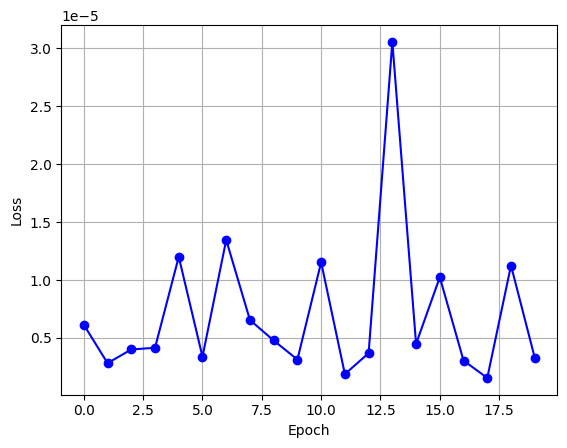

In [114]:
plt.plot(training_loss.keys(), training_loss.values(), marker='o', linestyle='-', color='b')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [101]:
def create_model_and_save(models, symbol, data, lr, epoch_length, shuffle_bool):
    model, training_loss, tensors = create_model(data, lr, epoch_length, shuffle_bool)
    models[symbol + ":" + str(lr) + ":" + str(epoch_length) + ":" + str(shuffle_bool)] = Model(model, training_loss, tensors, symbol, lr, epoch_length, shuffle_bool)
    return models

In [56]:
from collections import deque
class Trade:
    def __init__(self, price, direction, time):
        self.price = price
        self.direction = direction
        self.time = time
    def get_return(self, current_price):
        if self.direction == 'short':
            #return self.price-current_price
            return 0
        else:
            return current_price-self.price

def simulate(model, data, bank=0, hold=3):
    pricing_data = data['bars']['price_volume_weighted'].values
    bank = bank
    trades = deque([None] * hold)
    with torch.no_grad():
            model.eval()
            feature_scaled = list(zip(*[feature['value'] for feature in data['features_scaled'].values()]))
            model_outputs = model(torch.FloatTensor(feature_scaled))
            signals = model_outputs.numpy().squeeze()

            for time, signal in enumerate(signals):
                #print(trades)
                #create new trade
                price = pricing_data[time]
                if signal>0:
                    direction = 'long'
                else:
                    direction = 'short'
                new_trade = Trade(price, direction, time)
                trades.append(new_trade)
                #bank -= price

                #evaluate/sell old trade
                old_trade = trades.popleft()
                if old_trade is not None:
                    returns = old_trade.get_return(price)
                    bank += returns
    return bank

In [23]:
models = {}

In [86]:
create_model_and_save(models, 'NVDA', data['NVDA'], .0000001, 10, True)

{'NVDA:0.0001:10:True': <__main__.Model at 0x2dedde110>,
 'NVDA:1e-05:10:True': <__main__.Model at 0x2a4a93f40>,
 'NVDA:1e-06:10:True': <__main__.Model at 0x2ded79e40>,
 'NVDA:1e-08:10:True': <__main__.Model at 0x2d9686770>,
 'NVDA:1e-06:20:True': <__main__.Model at 0x2ded71600>,
 'NVDA:1e-06:11:True': <__main__.Model at 0x2a50be470>,
 'NVDA:1e-07:20:True': <__main__.Model at 0x2dedbb670>,
 'NVDA:1e-07:6:True': <__main__.Model at 0x2f2bfacb0>,
 'NVDA:1e-07:10:True': <__main__.Model at 0x2a3521180>}

In [95]:
#models['NVDA:1e-07:10:True'].graph_output(data['NVDA'], smooth_window=1, scale_center=118, scale_size=1)
#models['NVDA:1e-07:10:True'].graph_confusion()
models['NVDA:1e-07:20:True'].model


NeuralNetworkv2(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=64, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=128, out_features=64, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.1, inplace=False)
  )
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
)

##### graph feature
feature = data['NVDA']['features']['RSI']
feature2 = data['NVDA']['features_scaled']['RSI']

x=feature['timestamp']
y = feature['value']
y2=feature2['value']
colors = ['red' if val < 0 else 'green' for val in y.values]

#create plot
plt.figure(figsize=(15, 6))
plt.scatter(x, y, c='b', marker='o', s=5, edgecolors='none') 
#plt.scatter(x, y2, c='b', marker='o', s=5, edgecolors='none') 
plt.title(f'Time vs price')
plt.xlabel('Time')
plt.ylabel('price')
plt.grid(True)

In [38]:
data['NVDA']['features']['MACD']

,value,timestamp
0,7.647827,2022-11-14 05:00:00
1,8.819297,2022-11-15 05:00:00
2,9.117294,2022-11-16 05:00:00
3,9.071369,2022-11-17 05:00:00
4,8.578619,2022-11-18 05:00:00
...,...,...
290,14.099369,2024-01-11 05:00:00
291,15.971192,2024-01-12 05:00:00
292,18.413508,2024-01-16 05:00:00
293,19.757836,2024-01-17 05:00:00
